In [1]:
%cd /work/pi_wqd_umass_edu

/work/pi_wqd_umass_edu


In [2]:
!git clone https://github.com/jzuhone/pyxsim
%cd pyxsim
!git checkout absorption
!pip install -e.

Cloning into 'pyxsim'...
remote: Enumerating objects: 7125, done.
remote: Counting objects: 100% (1179/1179), done.
remote: Compressing objects: 100% (437/437), done.
remote: Total 7125 (delta 806), reused 1050 (delta 721), pack-reused 5946
Receiving objects: 100% (7125/7125), 72.28 MiB | 34.70 MiB/s, done.
Resolving deltas: 100% (5273/5273), done.
/work/pi_wqd_umass_edu/pyxsim
Branch 'absorption' set up to track remote branch 'absorption' from 'origin'.
Switched to a new branch 'absorption'
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///work/pi_wqd_umass_edu/pyxsim
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pyxsim (pyproject.toml) ... done
  Created wheel for pyxsim: filename=pyxsim-4.4.1.dev11+g3860c4d-0.editable-cp311-cp311-linux_x86_64.whl size=426

In [1]:
!pip install soxs

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install yt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install pyxsim

Defaulting to user installation because normal site-packages is not writeable


In [20]:
!pip install specutils

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import matplotlib
import soxs
matplotlib.rc('font', size = 18)

soxs : [WARNING  ] 2024-08-05 14:05:36,024 Setting 'soxs_data_dir' to /home/dkidwell_umass_edu/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [2]:
import yt
import pyxsim
import re
import struct
import sys
import warnings
from io import open
import h5py
import astropy
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage import rotate
from astropy import wcs
import astropy.units as u
from pprint import pprint

In [3]:
print("Numpy:      {}".format(np.__version__))
print("SOXS:     {}".format(soxs.__version__))
print("YT:     {}".format(yt.__version__))
print("Pyxsim:     {}".format(pyxsim.__version__))

Numpy:      1.26.4
SOXS:     4.8.4
YT:     4.3.1
Pyxsim:     4.4.1.dev11+g3860c4d


In [4]:
%cd /work/pi_wqd_umass_edu/pyxsim

/work/pi_wqd_umass_edu/pyxsim


In [6]:
from yt.units import Msun, pc, kyr
#loading data for athena++
Unit_Override = {"length_unit": (1.0, "pc"),
        "mass_unit": (1.0, "Msun"),
        "time_unit": (1.0, "kyr")}
ds = yt.load("torus_rst.out2.00350.athdf", units_override=Unit_Override, unit_system="cgs",
             magnetic_normalization="lorentz_heaviside",default_species_fields='ionized')

yt : [WARNING  ] 2024-08-05 14:05:43,009 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-08-05 14:05:43,010 Overriding length_unit: 1.0 pc.
yt : [INFO     ] 2024-08-05 14:05:43,011 Overriding time_unit: 1.0 kyr.
yt : [INFO     ] 2024-08-05 14:05:43,012 Overriding mass_unit: 1.0 Msun.
yt : [WARNING  ] 2024-08-05 14:05:43,013 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-08-05 14:05:43,071 Parameters: current_time              = 350.00012
yt : [INFO     ] 2024-08-05 14:05:43,071 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-08-05 14:05:43,072 Parameters: domain_left_edge          = [-5. -5. -5.]
yt : [INFO     ] 2024-08-05 14:05:43,072 Parameters: domain_right_edge         = [5. 5. 5.]
yt : [INFO     ] 2024-08-05 14:05:43,073 Parameters: cosmological_simulation   = 0


In [7]:
T_N = 10**4
def _neutral_h_density(field,data):
  nh = data['gas', 'H_nuclei_density']
  fac = np.zeros_like(nh.d)
  fac[data["gas","temperature"]< T_N] = 1.0
  return fac * nh

In [8]:
ds.add_field(("gas","H_p0_number_density"), _neutral_h_density, sampling_type="local", units="cm**-3")

In [9]:
dd = ds.all_data()

In [10]:
source_model = pyxsim.CIESourceModel("apec", 1.0, 10.0, 6000, Zmet = 3, kT_min = .025, kT_max = 20, max_density = 1.0e-18)

pyxsim : [INFO     ] 2024-08-05 14:05:55,123 kT_min = 0.025 keV
pyxsim : [INFO     ] 2024-08-05 14:05:55,125 kT_max = 20 keV


In [11]:
exp_time = (2000.0, "ks") #shorter exposure time because my computer has no memory.
area = (1500.0, "cm**2") 
redshift = 0 # its zero at first because it is local but I believe later I will be adding redshift.
dist = (8.18, "kpc")

In [12]:
print(ds.field_list)

[('athena_pp', 'press'), ('athena_pp', 'rho'), ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3')]


In [13]:

inclination_angle = np.deg2rad(66)
position_angle = np.deg2rad(22)

In [14]:
# since the model is made on the Galactic plane we need to rotate it to an inclination of 66 deg and a position angle of 22 deg
from scipy.ndimage import rotate

inclination_angle = np.deg2rad(66)
position_angle = np.deg2rad(22)

#yflip2 = np.deg2rad(90)



# Define rotation matrix around z-axis (position angle)
Rtot = np.array([[np.cos(inclination_angle), np.sin(inclination_angle)*np.sin(position_angle), -np.sin(inclination_angle)*np.cos(position_angle)],
               [0, np.cos(position_angle), np.sin(position_angle)],
               [np.sin(inclination_angle), -np.cos(inclination_angle)*np.sin(position_angle), np.cos(inclination_angle)*np.cos(position_angle)]])




Rfin = np.linalg.inv(Rtot)



Thenormal_vector = Rfin[:,2]  #column
Thenorth_vector = Rfin[:,1]  #column
Theother_vector = Rfin[:,0]  
#Thenormal_vector1 = Rtest[:,2]  # Testing for other rotations
#Thenorth_vector1 = Rtest[:,1]  # Testing for other rotations



print("Rotation Matrix:")
print(Rfin)
#print(Rtest)
#print(Thenormal_vector1*-1)
#print(Thenorth_vector1*-1)
print("normal:")
print(Thenormal_vector)
print("North:")
print(Thenorth_vector)
print("---")
print ("Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up")
print("---")
print("Mirror Normal:")
print(Thenormal_vector*(-1))
print("Mirror North:")
print(Thenorth_vector*(-1))

print("The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North")
print("The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above")
print ("---")
L = [ 0.91354546, 0.15236623,  -0.37711965] # vector normal to cutting plane
north_vector = [ 3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]
print("USE THIS NORMAL: <--")
print(L)
print("USE THIS NORTH: <--")
print(north_vector)

Rotation Matrix:
[[ 4.06736643e-01 -3.09322785e-17  9.13545458e-01]
 [ 3.42220152e-01  9.27183855e-01 -1.52366228e-01]
 [-8.47024599e-01  3.74606593e-01  3.77119649e-01]]
normal:
[ 0.91354546 -0.15236623  0.37711965]
North:
[-3.09322785e-17  9.27183855e-01  3.74606593e-01]
---
Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up
---
Mirror Normal:
[-0.91354546  0.15236623 -0.37711965]
Mirror North:
[ 3.09322785e-17 -9.27183855e-01 -3.74606593e-01]
The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North
The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above
---
USE THIS NORMAL: <--
[0.91354546, 0.15236623, -0.37711965]
USE THIS NORTH: <--
[0.374606593, -0.927183855, 0.374606593]


In [15]:
# This is a new routine to compute the column density map
nwidth = (128)  # number of pixels in the width of the Athena map
ndepth = (128)  # number of pixels in the depth of the Athena map
width=(float(10.0), "pc") #width of simulation cube
depth = (float(10.0), "pc") #depth of simulation cube
c = ds.arr([0.0, 0.0, 0.0], "code_length") #setting the center


L = [ 9.1354546e-01, 1.5236623e-01,  -3.7711965e-01] # vector normal to cutting plane
N = [0.374606593, -0.927183855, 0.374606593] #the North (upward facing) vector

pyxsim.make_column_density_map(ds, L, c, width, depth, nwidth, ndepth, "internal_abs_REV.h5", north_vector=N,)



Determining a cube of neutral hydrogen column density :   0%|          | 0/128 [00:00<?, ?it/s]

In [16]:
#making photons (this takes a fuck ton of time) I would recommend using a cluster for this it makes it 100x more efficient 
n_photons, n_cells = pyxsim.make_photons("my_photonstestMHD15m2Ms", dd, redshift,area, exp_time, source_model, dist = dist)

pyxsim : [INFO     ] 2024-08-05 14:14:08,032 Observing local source at distance 8.18.
pyxsim : [INFO     ] 2024-08-05 14:14:08,035 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2024-08-05 14:14:08,035 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/118 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/17235968 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-08-05 14:26:46,457 Finished generating photons.
pyxsim : [INFO     ] 2024-08-05 14:26:46,458 Number of photons generated: 32869633
pyxsim : [INFO     ] 2024-08-05 14:26:46,459 Number of cells with photons: 2478573


In [17]:
L = [ 0.91354546, 0.15236623,  -0.37711965]
North_vector = [3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]
n_events = pyxsim.project_photons("my_photonstestMHD15m2Ms", "my_photonstestMHD_REVabs_dp15m2Ms",L ,(266.42, -29),nH = 11,
                                  absorb_model = "tbabs", no_shifting = False, north_vector = North_vector, column_file = "internal_abs_REV.h5")

pyxsim : [INFO     ] 2024-08-05 14:26:46,496 Foreground galactic absorption: using the tbabs model and nH = 11.
pyxsim : [INFO     ] 2024-08-05 14:26:46,497 Internal absorption: using the tbabs model and column density map internal_abs_REV.h5.


Projecting photons from cells/particles :   0%|          | 0/2478573 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-08-05 14:27:42,654 Detected 238920 events.


In [18]:
#second time for no_shifting = true so there is a doppler shift
n_events = pyxsim.project_photons("my_photonstestMHD15m2Ms", "my_photonstestMHD_REVabs_dp15m2Ms",L ,(266.42, -29),nH = 11,
                                  absorb_model = "tbabs", no_shifting = True, north_vector = North_vector, column_file = "internal_abs_REV.h5")

pyxsim : [INFO     ] 2024-08-05 14:27:42,697 Foreground galactic absorption: using the tbabs model and nH = 11.
pyxsim : [INFO     ] 2024-08-05 14:27:42,697 Internal absorption: using the tbabs model and column density map internal_abs_REV.h5.


Projecting photons from cells/particles :   0%|          | 0/2478573 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-08-05 14:28:38,070 Detected 239583 events.


In [19]:
n_events_no_abs = pyxsim.project_photons("my_photonstestMHD15m2Ms", "no_abs_my_photonstestMHD_REVabs_dp15m2Ms",L ,(266.42, -29),nH = 11,
                                   no_shifting = True, north_vector = North_vector)

Projecting photons from cells/particles :   0%|          | 0/2478573 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2024-08-05 14:28:48,153 Detected 32869633 events.


In [20]:
events = pyxsim.EventList("no_abs_my_photonstestMHD_REVabs_dp15m2Ms.h5")
events.write_to_simput("No_REVabsorption_MHD_dp15m2Ms", overwrite = True)

soxs : [WARNING  ] 2024-08-05 14:28:51,753 Overwriting No_REVabsorption_MHD_dp15m2Ms_phlist.fits.
soxs : [INFO     ] 2024-08-05 14:28:52,382 Writing source 'No_REVabsorption_MHD_dp15m2Ms' to No_REVabsorption_MHD_dp15m2Ms_phlist.fits.


In [21]:
events2 = pyxsim.EventList("my_photonstestMHD_REVabs_dp15m2Ms.h5")
events2.write_to_simput("REVabsorption_MHD_dp15m2Ms", overwrite = True)

soxs : [WARNING  ] 2024-08-05 14:28:54,609 Overwriting REVabsorption_MHD_dp15m2Ms_phlist.fits.
soxs : [INFO     ] 2024-08-05 14:28:54,677 Writing source 'REVabsorption_MHD_dp15m2Ms' to REVabsorption_MHD_dp15m2Ms_phlist.fits.


In [22]:
# make new instrument based on Chandra cycle 13
from soxs import get_instrument_from_registry, add_instrument_to_registry
new_chandra = get_instrument_from_registry("chandra_aciss_cy22")
new_chandra["name"] = "2chandra_aciss_sgra_cy13" # Must change the name, otherwise an error will be thrown
new_chandra["arf"] = "asgras_src.arf" # arf of cycle 13
new_chandra["rmf"] = "asgras_src.rmf" # rmf of cycle 13


name = add_instrument_to_registry(new_chandra)

In [33]:
#Simulate observing with chandra
# for spectral analysis purposes turn off instrument background (easier to compare with unconvolved spectrum for pyxsim)
soxs.instrument_simulator("REVabsorption_MHD_dp15m2Ms_phlist.fits._simput.fits", "REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", (230.0,"ks"),"chandra_acisi_cy22", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=False)
#all of these are the potential instruments I have used 
#and lynx_lxm is overall the best but may need smaller observation times. (there is also a unkown error preventing us from currently using lynx)
#"xrism_resolve" (works)
#"lynx_lxm" (doesn't work)
#"chandra_acisi_cy22" (works)

soxs : [INFO     ] 2024-08-05 14:30:21,547 Making observation of source in REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-08-05 14:30:21,679 Detecting events from source REVabsorption_MHD_dp15m2Ms_phlist.fits..
soxs : [INFO     ] 2024-08-05 14:30:21,680 Applying energy-dependent effective area from acisi_aimpt_cy22.arf.
soxs : [INFO     ] 2024-08-05 14:30:21,688 Pixeling events.
soxs : [INFO     ] 2024-08-05 14:30:21,689 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-08-05 14:30:21,740 4096 events were detected from the source.
soxs : [INFO     ] 2024-08-05 14:30:21,742 Scattering energies with RMF acisi_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/4096 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-08-05 14:30:21,875 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-08-05 14:30:21,876 Writing events to file REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-08-05 14:30:21,941 Observation complete.


In [34]:
# for spectral analysis purposes turn off instrument background (easier to compare with unconvolved spectrum for pyxsim)
soxs.instrument_simulator("No_REVabsorption_MHD_dp15m2Ms_simput.fits", "No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", (230.0,"ks"),"chandra_acisi_cy22", 
                          [266.42, -29], overwrite=True, ptsrc_bkgnd=False,foreground=False,instr_bkgnd=False)

soxs : [INFO     ] 2024-08-05 14:30:24,982 Making observation of source in No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-08-05 14:30:26,502 Detecting events from source No_REVabsorption_MHD_dp15m2Ms.
soxs : [INFO     ] 2024-08-05 14:30:26,502 Applying energy-dependent effective area from acisi_aimpt_cy22.arf.
soxs : [INFO     ] 2024-08-05 14:30:28,665 Pixeling events.
soxs : [INFO     ] 2024-08-05 14:30:28,782 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-08-05 14:30:28,946 449209 events were detected from the source.
soxs : [INFO     ] 2024-08-05 14:30:28,970 Scattering energies with RMF acisi_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/449209 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-08-05 14:30:29,259 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-08-05 14:30:29,260 Writing events to file No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits.
soxs : [INFO     ] 2024-08-05 14:30:29,417 Observation complete.


In [35]:
soxs.write_image("REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits","REVabs_MHD_dp15m2Ms_lynx230ks_img.fits", overwrite=True)

In [36]:
soxs.write_image("No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits","No_REVabs_MHD_dp15m2Ms_lynx230ks_img.fits", overwrite=True)

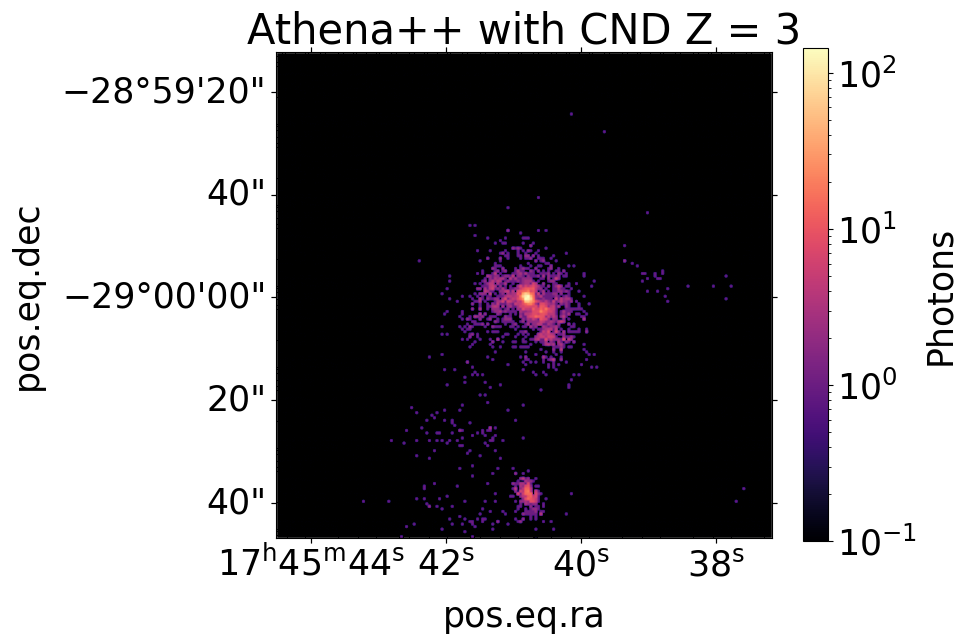

In [37]:
#printing image
width = 400
with fits.open("REVabs_MHD_dp15m2Ms_lynx230ks_img.fits")as f:
  hdu = f["IMAGE"]
  wcs = WCS(hdu.header)
  center = wcs.wcs.crpix
  fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=wcs))
  p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
  ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
  ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width)
  ax.set_facecolor('black')
  ax.xaxis.label.set_color('white')
  ax.set_title("Athena++ with CND Z = 3")
  fig.colorbar(p,label = 'Photons',shrink=0.80)

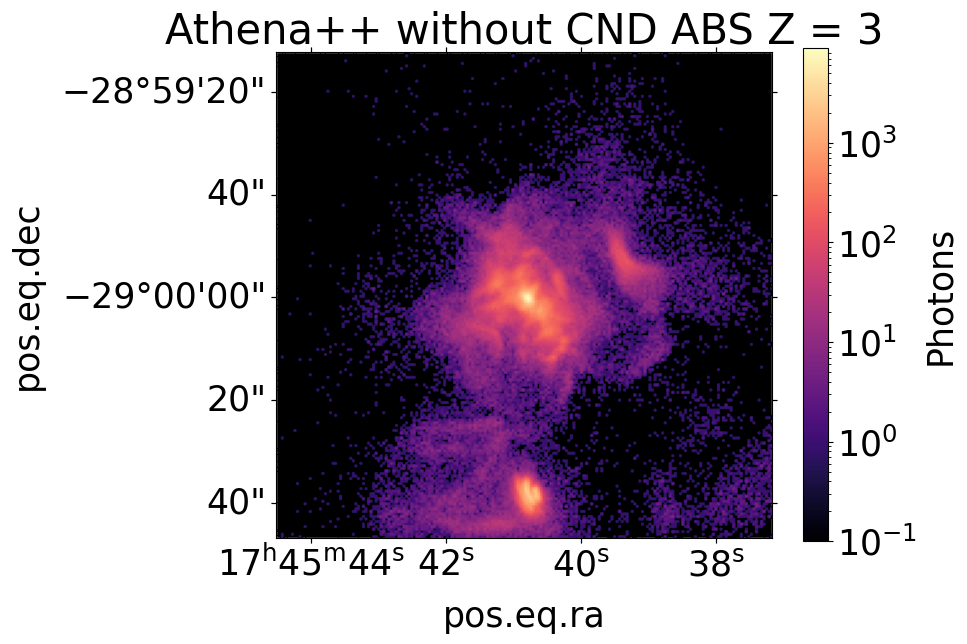

In [38]:
#printing image
width = 400
with fits.open("No_REVabs_MHD_dp15m2Ms_lynx230ks_img.fits")as f:
  hdu = f["IMAGE"]
  wcs = WCS(hdu.header)
  center = wcs.wcs.crpix
  fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=wcs))
  p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
  ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
  ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width)
  ax.set_facecolor('black')
  ax.xaxis.label.set_color('white')
  ax.set_title("Athena++ without CND ABS Z = 3")
  fig.colorbar(p,label = 'Photons',shrink=0.80)

yt : [INFO     ] 2024-07-24 17:08:14,374 xlim = -3.500000 3.500000
yt : [INFO     ] 2024-07-24 17:08:14,377 ylim = -3.500000 3.500000
yt : [INFO     ] 2024-07-24 17:08:14,378 zlim = -5.000000 5.000000
yt : [INFO     ] 2024-07-24 17:08:14,381 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



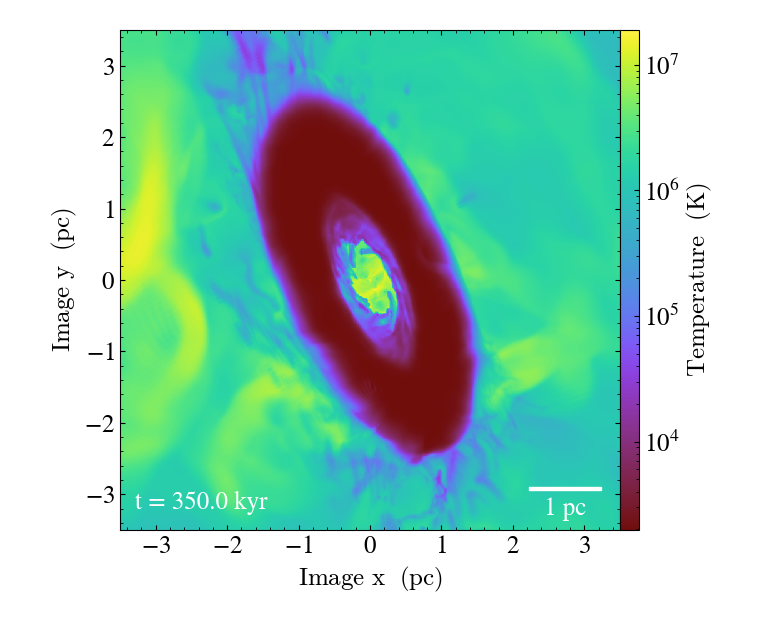

In [46]:
#making a projection plot of the data set just to see what we are putting into our simulations. (You should probably do this earlier than I did)
prj = yt.ProjectionPlot(
    ds, L, ('gas', 'temperature'), weight_field=("gas", "density"), width=(7, "pc"),north_vector=N, method = ("integrate")
)

prj.set_width((7, "pc"))
prj.set_axes_unit("pc")
prj.annotate_scale()
prj.annotate_timestamp()
prj.set_figure_size(5)
prj.show()

In [6]:
#making difference map (still haven't done this correctly)
absfile = 'REVabs_MHD_dp15m2Ms_lynx230ks_img.fits'
noabsfile = 'No_REVabs_MHD_dp15m2Ms_lynx230ks_img.fits'
hdul = fits.open(absfile)
hdul2 = fits.open(noabsfile)
absd = hdul[0].data
noabsd = hdul2[0].data
vals = (noabsd - absd) / noabsd
fits.writeto('difference_map_img.fits', vals, overwrite = True)

/tmp/ipykernel_1889847/1331663590.py:7: RuntimeWarning: divide by zero encountered in divide
  vals = (noabsd - absd) / noabsd
/tmp/ipykernel_1889847/1331663590.py:7: RuntimeWarning: invalid value encountered in divide
  vals = (noabsd - absd) / noabsd


In [21]:
hdu_list = fits.open("difference_map_img.fits")
hdu_list.info()

Filename: difference_map_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (4880, 4880)   float64   


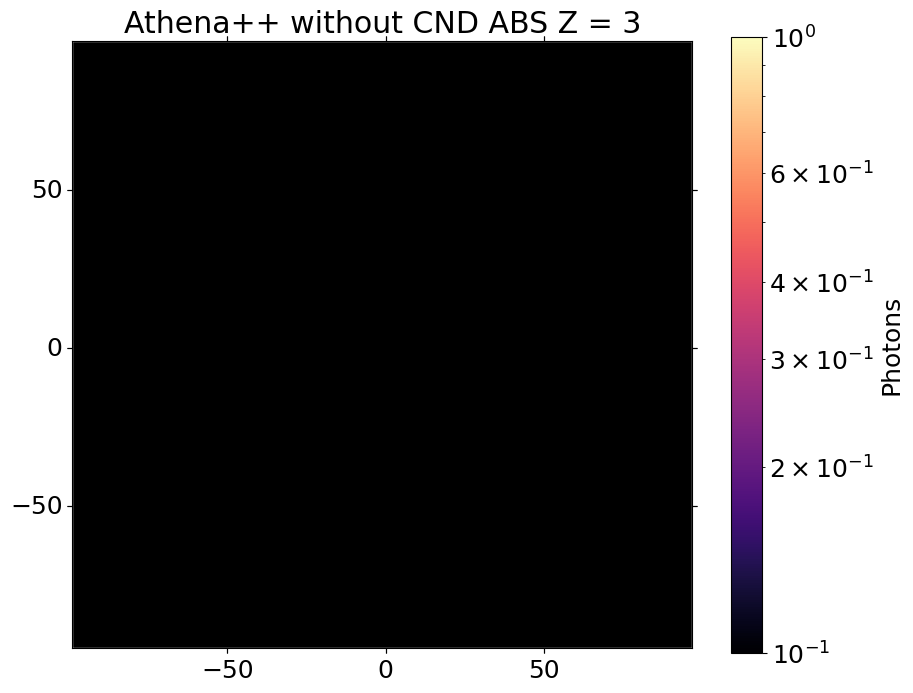

In [8]:
#printing image
width = 400
with fits.open("difference_map_img.fits")as f:
  hdu = f["PRIMARY"]
  wcs = WCS(hdu.header)
  center = wcs.wcs.crpix
  fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
  p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
  ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
  ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width)
  ax.set_facecolor('black')
  ax.xaxis.label.set_color('white')
  ax.set_title("Athena++ without CND ABS Z = 3")
  fig.colorbar(p,label = 'Photons',shrink=0.80)

In [45]:
#writing spectrum from pyxsim
ra0, dec0 = 266.42, -29 # center coords of image, from event file (updated to proper degrees)
nx = 255 # size of image, got from file (remember to update if you use a cut version)
#x=255 y=130 what is that in pixel space
dx = 0.5*u.arcsec # pixel size, you told me

In [46]:
specfile = "myspec.fits" # filename to write to
emin = 0.1 # minimum energy of spectrum
emax = 11.0 # maximum energy of spectrum
nchan = 2000 # number of bins in spectrum
events.write_spectrum(specfile, emin, emax, nchan, overwrite=True)

In [47]:
specfile2 = "myspec2.fits" # filename to write to
emin = 0.1 # minimum energy of spectrum
emax = 10.0 # maximum energy of spectrum
nchan = 2000 # number of bins in spectrum
events2.write_spectrum(specfile2, emin, emax, nchan, overwrite=True)

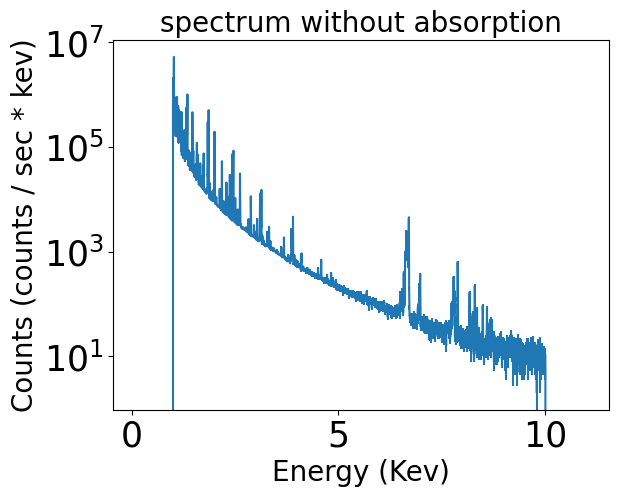

In [55]:
#no absorption spectra
f = fits.open("myspec.fits")

e = f["SPECTRUM"].data["ENERGY"]
c = f["SPECTRUM"].data["COUNTS"]
c_err = np.sqrt(c)
fig, ax = plt.subplots()
ax.set_title("spectrum without absorption",fontsize = 20)
ax.set_ylabel("Counts (counts / sec * kev)",fontsize=20)
ax.set_xlabel("Energy (Kev)",fontsize=20)
ax.errorbar(e, c, yerr=c_err)
ax.set_yscale("log")

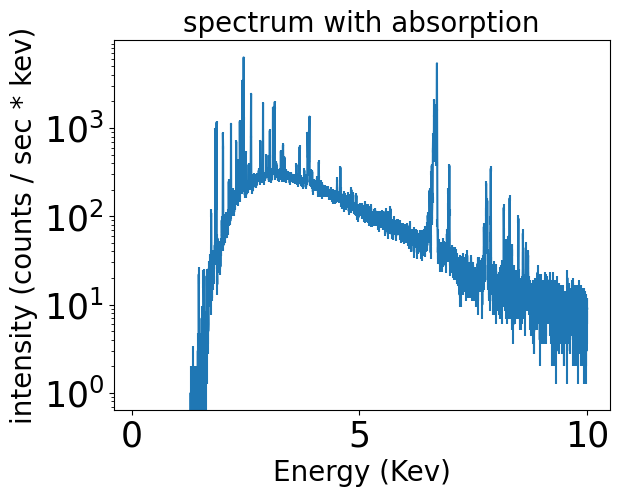

In [56]:
#absorption spectra
f = fits.open("myspec2.fits")

e = f["SPECTRUM"].data["ENERGY"]
c = f["SPECTRUM"].data["COUNTS"]
c_err = np.sqrt(c)
fig, ax = plt.subplots()
ax.set_title("spectrum with absorption",fontsize=20)
ax.set_ylabel("intensity (counts / sec * kev)",fontsize=20)
ax.set_xlabel("Energy (Kev)",fontsize=20)
ax.errorbar(e, c, yerr=c_err)
ax.set_yscale("log")

In [39]:
#writing the spectra with soxs for this you must use event files from instrument simulator!!
soxs.write_spectrum("REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", "absorption_test_spectrum_evt.pha",overwrite=True) 
soxs.write_spectrum("No_REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits","no_absorption_test_spectrum_evt.pha",overwrite=True)

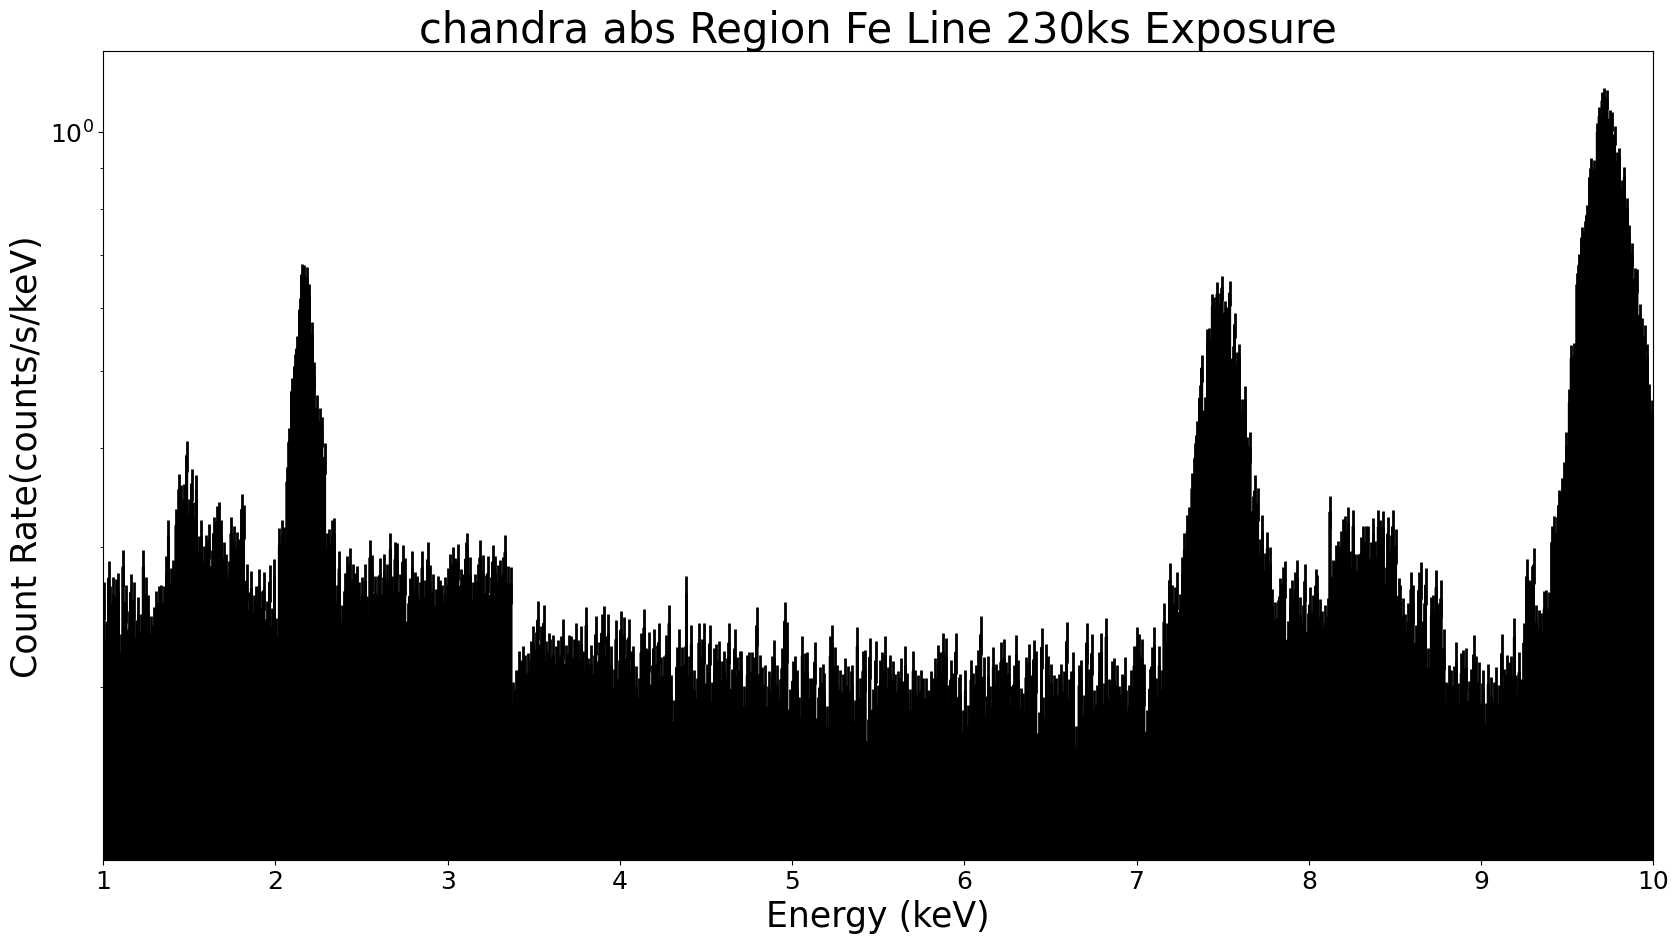

In [40]:
ebin = np.linspace(1,15,2500)
fig, ax = soxs.plot_spectrum("absorption_test_spectrumevt.pha",xscale = 'linear',plot_energy=True, xmin=1,xmax = 10.0, noerr=False ,lw=2,ebins=ebin,label = 'Without doppler',color = 'black')
plt.rcParams['font.size'] = '25'
x = np.linspace(1,10,10)
values= np.linspace(1,10,10)
#plt.xticks(x,values,fontsize=25)
#plt.yticks(fontsize=25)
plt.xlabel('Energy (keV)', fontsize=25)
plt.ylabel('Count Rate(counts/s/keV)', fontsize=25)
plt.title('chandra abs Region Fe Line 230ks Exposure')
#plt.ylim(0.001,0.1) #for lynx
fig.set_size_inches(20, 10.5) 

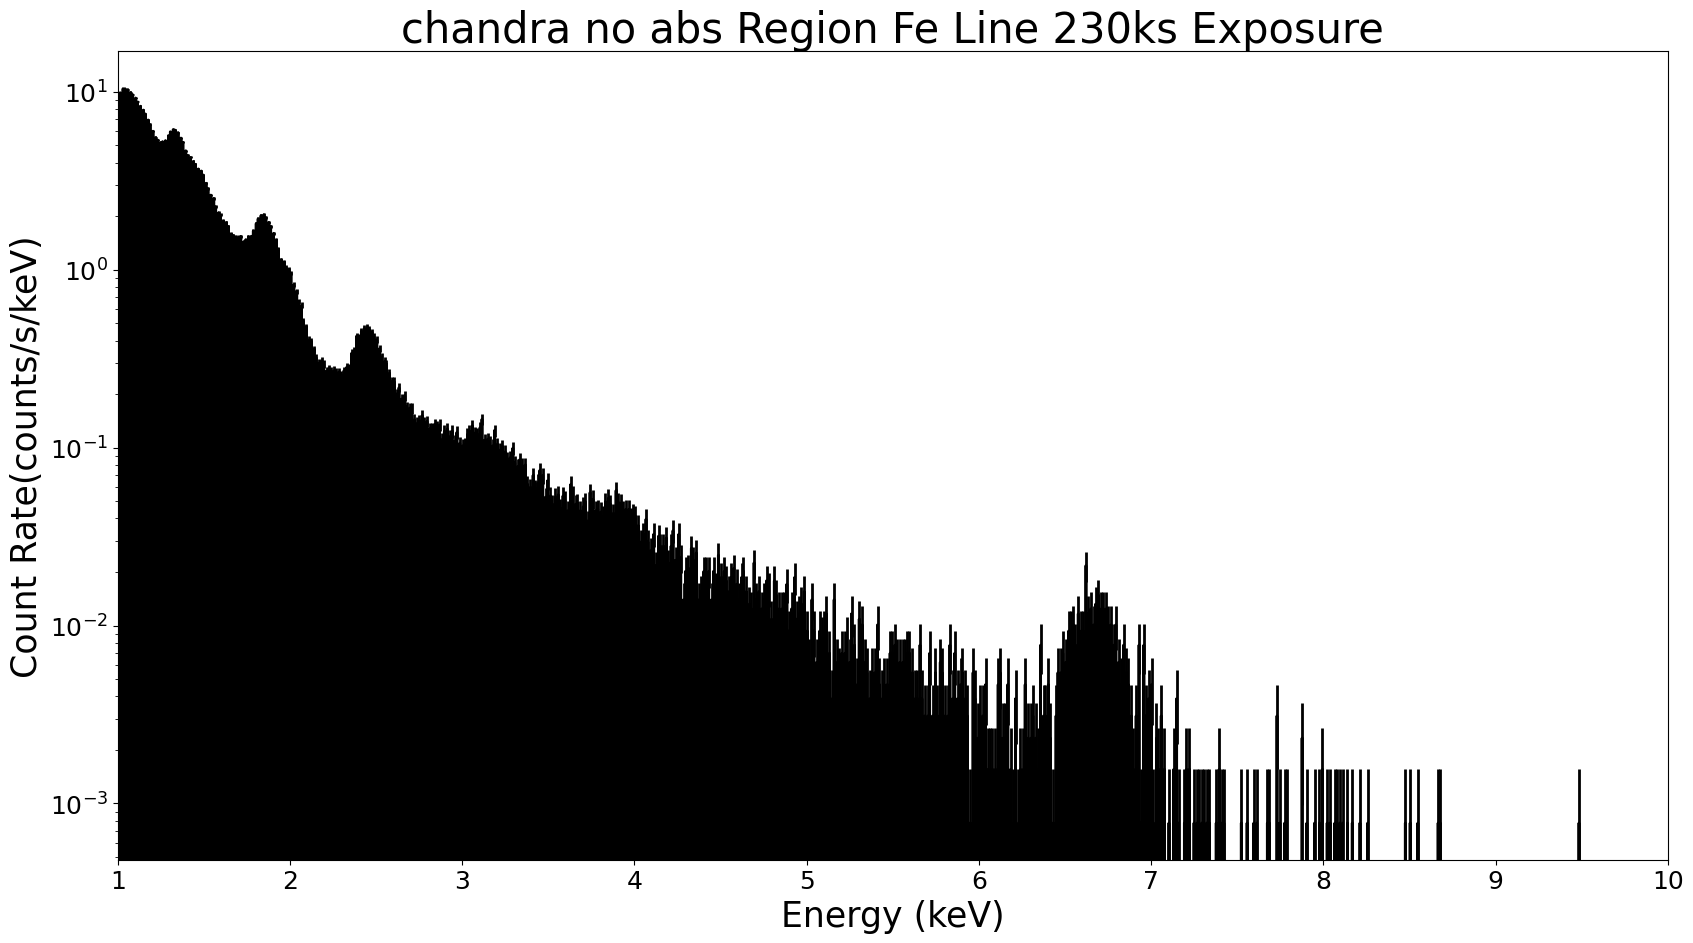

In [41]:
ebin = np.linspace(1,15,2500)
fig, ax = soxs.plot_spectrum("no_absorption_test_spectrum_evt.pha",xscale = 'linear',plot_energy=True, xmin=1,xmax = 10.0, noerr=False ,lw=2,ebins=ebin,label = 'Without doppler',color = 'black')
plt.rcParams['font.size'] = '25'
x = np.linspace(1,10,10)
values= np.linspace(1,10,10)
#plt.xticks(x,values,fontsize=25)
#plt.yticks(fontsize=25)
plt.xlabel('Energy (keV)', fontsize=25)
plt.ylabel('Count Rate(counts/s/keV)', fontsize=25)
plt.title('chandra no abs Region Fe Line 230ks Exposure')
#plt.ylim(0.001,0.1) #for lynx
fig.set_size_inches(20, 10.5) 